In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [2]:
link = 'https://drive.google.com/file/d/1C3981kVZnd86sHj7sQZ7aVQKXU0udUYe/view?usp=sharing'



id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('drought.csv')

df = pd.read_csv('drought.csv')
print(df)


      SCORE       DATE    D0    D1    D2   D3   D4  NA_COUNT    W0   W1   W2  \
0       1.1     year_0   0.0   0.0   0.0  0.0  0.0       0.0  98.9  0.0  0.0   
1      92.2     year_1   7.8   0.0   0.0  0.0  0.0       0.0   0.0  0.0  0.0   
2       6.3     year_2  93.7  42.0   0.0  0.0  0.0       0.0   0.0  0.0  0.0   
3       3.2     year_3  96.8  71.3   0.0  0.0  0.0       0.0   0.0  0.0  0.0   
4      44.8     year_4  55.2   0.0   0.0  0.0  0.0       0.0   0.0  0.0  0.0   
...     ...        ...   ...   ...   ...  ...  ...       ...   ...  ...  ...   
2013    9.0  year_2013  91.1  69.4  28.1  1.1  0.0       0.0   0.0  0.0  0.0   
2014   12.1  year_2014  87.9  45.6   6.7  0.0  0.0       0.0   0.0  0.0  0.0   
2015   42.9  year_2015  33.8  13.5   4.4  0.0  0.0       0.0  23.3  4.4  1.1   
2016   33.4  year_2016  63.4  25.4   6.6  0.0  0.0       0.0   3.1  0.0  0.0   
2017   59.3  year_2017  35.4   8.9   2.2  0.0  0.0       0.0   5.3  1.0  0.0   

       W3   W4  
0     0.0  0.0  
1    

In [51]:
df.head()

,SCORE,DATE,D0,D1,D2,D3,D4,NA_COUNT,W0,W1,W2,W3,W4,Date_MOD
0,1.1,year_0,0.0,0.0,0.0,0.0,0.0,0.0,98.9,0.0,0.0,0.0,0.0,0
1,92.2,year_1,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6.3,year_2,93.7,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,3.2,year_3,96.8,71.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,44.8,year_4,55.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [52]:
df.shape

(2018, 14)

In [53]:
df.isnull().sum()

SCORE       0
DATE        0
D0          0
D1          0
D2          0
D3          0
D4          0
NA_COUNT    0
W0          0
W1          0
W2          0
W3          0
W4          0
Date_MOD    0
dtype: int64

In [3]:
summer_yearly=df

In [4]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
#Decompose a time series into trend, season, and residual components
def decompose_series(df, var, period):
    analysis = df[var]
    decompose_result_mult = seasonal_decompose(analysis, model="additive", period=period, extrapolate_trend='freq')
    trend = decompose_result_mult.trend
    season = decompose_result_mult.seasonal
    resid = decompose_result_mult.resid
    return trend, season, resid

In [6]:
summer_yearly['Date_MOD'] = summer_yearly['DATE'].str.split('_').str[1].astype(int)

In [7]:
tr, sea, resid = decompose_series(summer_yearly, 'D0', 50)

In [8]:
d_training_scaled = tr[:1900]

In [9]:
d_training_scaled.shape

(1900,)

In [10]:
features_set = []
labels = []
for i in range(50, 1900):
    features_set.append(d_training_scaled[i-50:i])
    labels.append(d_training_scaled[i])

In [11]:
features_set, labels = np.array(features_set), np.array(labels)

In [12]:
features_set.shape

(1850, 50)

In [13]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [14]:
features_set.shape

(1850, 50, 1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
model = Sequential()

In [17]:
model.add(LSTM(units=300, return_sequences=True, input_shape=(features_set.shape[1], 1)))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units=100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [18]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 300)           362400    
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           160400    
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

In [20]:
model.fit(features_set, labels, epochs = 300, batch_size = 32)

Epoch 1/300
58/58 [==============================] - 10s 15ms/step - loss: 542.1472
Epoch 2/300
58/58 [==============================] - 1s 13ms/step - loss: 245.2994
Epoch 3/300
58/58 [==============================] - 1s 12ms/step - loss: 146.4939
Epoch 4/300
58/58 [==============================] - 1s 12ms/step - loss: 100.7855
Epoch 5/300
58/58 [==============================] - 1s 12ms/step - loss: 83.5049
Epoch 6/300
58/58 [==============================] - 1s 12ms/step - loss: 77.0721
Epoch 7/300
58/58 [==============================] - 1s 12ms/step - loss: 75.9475
Epoch 8/300
58/58 [==============================] - 1s 12ms/step - loss: 74.7450
Epoch 9/300
58/58 [==============================] - 1s 12ms/step - loss: 74.9148
Epoch 10/300
58/58 [==============================] - 1s 12ms/step - loss: 74.5257
Epoch 11/300
58/58 [==============================] - 1s 16ms/step - loss: 75.1387
Epoch 12/300
58/58 [==============================] - 1s 16ms/step - loss: 75.2693
Epoch 13

In [21]:
d_testing_processed = tr[1900:]

In [22]:
len(d_testing_processed)

118

In [23]:
test_features = []
for i in range(50, len(d_testing_processed)):
    test_features.append(d_testing_processed[i-50:i])

In [24]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [25]:
predictions = model.predict(test_features)

3/3 [==============================] - 1s 22ms/step


In [55]:
test_features[0]

array([[29.35 ],
       [29.047],
       [28.271],
       [28.094],
       [27.146],
       [25.198],
       [24.291],
       [23.499],
       [22.031],
       [22.449],
       [23.882],
       [25.314],
       [25.345],
       [24.097],
       [23.933],
       [24.846],
       [25.644],
       [25.644],
       [24.644],
       [22.843],
       [22.042],
       [21.57 ],
       [21.098],
       [21.1  ],
       [20.134],
       [18.478],
       [17.937],
       [17.084],
       [17.011],
       [18.344],
       [19.619],
       [21.429],
       [22.37 ],
       [22.37 ],
       [23.37 ],
       [24.972],
       [26.574],
       [27.574],
       [28.051],
       [28.992],
       [29.456],
       [29.6  ],
       [29.8  ],
       [29.856],
       [29.65 ],
       [29.444],
       [29.802],
       [30.539],
       [30.918],
       [31.378]])

In [57]:
import pickle

# Save the model to a file
with open('drought_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [26]:
d_testing_processed.index[50:]

RangeIndex(start=1950, stop=2018, step=1)

In [27]:
predictions = np.hstack(predictions)

In [28]:
predictions

array([32.105167, 31.08739 , 31.362064, 33.21762 , 33.12703 , 33.15625 ,
       33.345676, 31.952148, 32.42734 , 31.452774, 29.121964, 28.859558,
       27.12767 , 27.594696, 28.379932, 29.161114, 29.500275, 31.139732,
       32.260704, 32.27508 , 34.18859 , 33.998737, 34.1809  , 34.515953,
       34.483635, 34.674168, 36.12849 , 35.7543  , 37.80442 , 37.878853,
       37.249638, 35.86728 , 35.02048 , 37.133343, 37.26539 , 36.523018,
       35.229496, 33.803078, 35.596436, 36.56151 , 36.886337, 38.083035,
       38.402622, 39.473686, 35.34294 , 39.20353 , 36.44133 , 38.84311 ,
       37.201797, 38.80847 , 37.629032, 39.010986, 38.03572 , 39.186543,
       38.476196, 39.379326, 38.875034, 39.621384, 39.24504 , 39.878742,
       39.60496 , 40.141373, 39.957703, 40.414356, 40.303   , 40.69951 ,
       40.641582, 40.988586], dtype=float32)

In [29]:
predictions = pd.Series(predictions, index=d_testing_processed.index[50:])

In [30]:
d_testing_processed

1900    29.350000
1901    29.047000
1902    28.271000
1903    28.094000
1904    27.146000
          ...    
2013    40.794224
2014    40.960290
2015    41.126357
2016    41.292424
2017    41.458491
Name: trend, Length: 118, dtype: float64

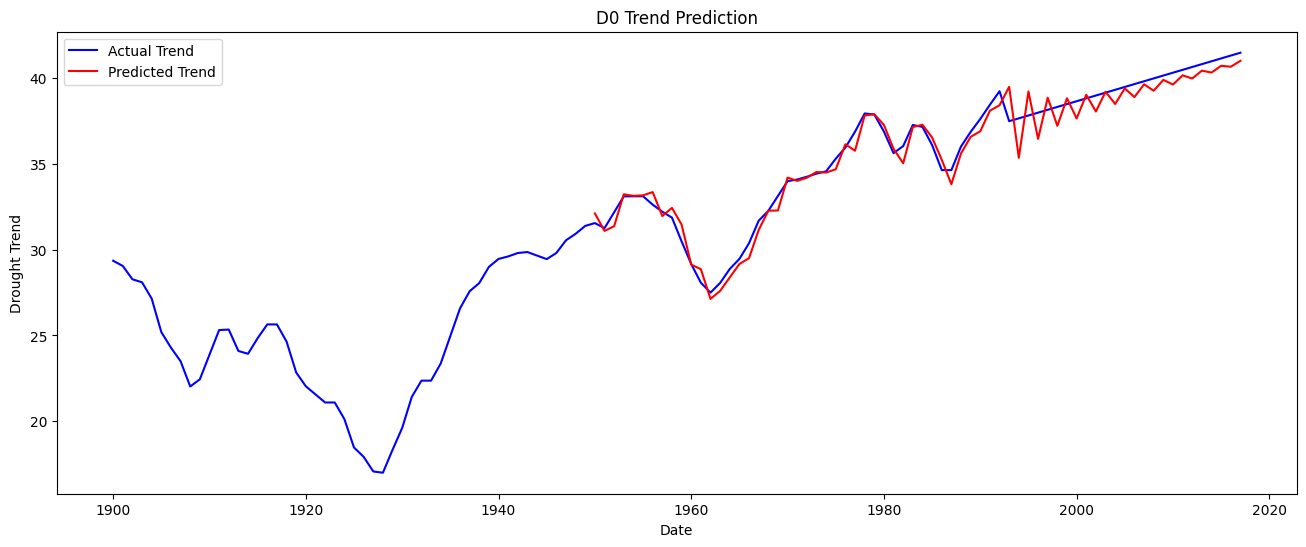

In [31]:
plt.figure(figsize=(16,6))
plt.plot(d_testing_processed, color='blue', label='Actual Trend')
plt.plot(predictions , color='red', label='Predicted Trend')
plt.title('D0 Trend Prediction')
plt.xlabel('Date')
plt.ylabel('Drought Trend')
plt.legend()
plt.show()

In [32]:
d_sea_training_scaled = sea[:1900]

In [33]:
sea_features_set = []
sea_labels = []
for i in range(50, 1900):
    sea_features_set.append(d_sea_training_scaled[i-50:i])
    sea_labels.append(d_sea_training_scaled[i])

In [34]:
sea_features_set, sea_labels = np.array(sea_features_set), np.array(sea_labels)

In [35]:
sea_features_set = np.reshape(sea_features_set, (sea_features_set.shape[0], sea_features_set.shape[1], 1))

In [36]:
s_model = Sequential()

In [37]:
s_model.add(LSTM(units=300, return_sequences=True, input_shape=(features_set.shape[1], 1)))

s_model.add(LSTM(units=100, return_sequences=True))
s_model.add(Dropout(0.2))

s_model.add(LSTM(units=100, return_sequences=True))
s_model.add(Dropout(0.2))


s_model.add(LSTM(units=100))
s_model.add(Dropout(0.2))

s_model.add(Dense(units = 1))

s_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
s_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 300)           362400    
                                                                 
 lstm_5 (LSTM)               (None, 50, 100)           160400    
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)              

In [39]:
s_model.fit(sea_features_set, sea_labels, epochs = 300, batch_size = 32)

Epoch 1/300
58/58 [==============================] - 7s 17ms/step - loss: 28.1189
Epoch 2/300
58/58 [==============================] - 1s 16ms/step - loss: 23.8662
Epoch 3/300
58/58 [==============================] - 1s 14ms/step - loss: 20.7204
Epoch 4/300
58/58 [==============================] - 1s 12ms/step - loss: 17.0524
Epoch 5/300
58/58 [==============================] - 1s 12ms/step - loss: 16.3035
Epoch 6/300
58/58 [==============================] - 1s 12ms/step - loss: 15.8520
Epoch 7/300
58/58 [==============================] - 1s 12ms/step - loss: 16.9076
Epoch 8/300
58/58 [==============================] - 1s 12ms/step - loss: 15.6783
Epoch 9/300
58/58 [==============================] - 1s 12ms/step - loss: 15.4920
Epoch 10/300
58/58 [==============================] - 1s 12ms/step - loss: 15.2304
Epoch 11/300
58/58 [==============================] - 1s 12ms/step - loss: 15.4849
Epoch 12/300
58/58 [==============================] - 1s 12ms/step - loss: 15.2309
Epoch 13/300


In [40]:
s_testing_processed = sea[1900:]

In [41]:
s_test_features = []
for i in range(50, len(s_testing_processed)):
    s_test_features.append(s_testing_processed[i-50:i])

In [42]:
s_test_features = np.array(s_test_features)
s_test_features = np.reshape(s_test_features, (s_test_features.shape[0], s_test_features.shape[1], 1))
s_predictions = s_model.predict(s_test_features)

In [43]:
s_predictions = s_model.predict(s_test_features)

3/3 [==============================] - 1s 8ms/step


In [44]:
s_predictions = np.hstack(s_predictions)

In [45]:
s_predictions = pd.Series(s_predictions, index=s_testing_processed.index[50:])

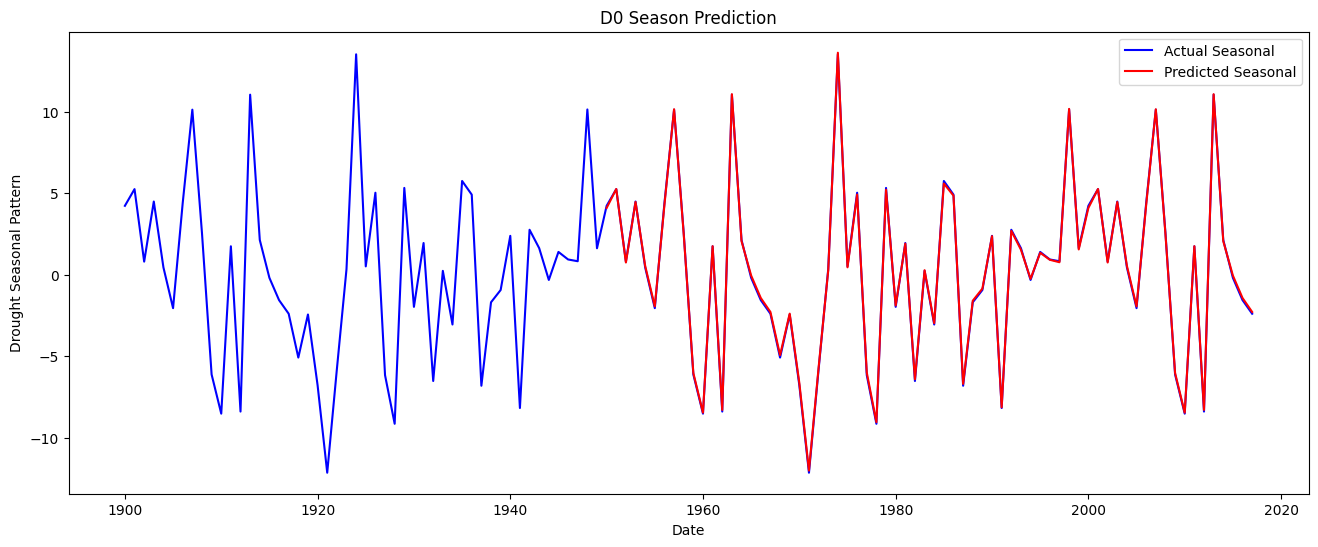

In [46]:
plt.figure(figsize=(16,6))
plt.plot(s_testing_processed, color='blue', label='Actual Seasonal')
plt.plot(s_predictions , color='red', label='Predicted Seasonal')
plt.title('D0 Season Prediction')
plt.xlabel('Date')
plt.ylabel('Drought Seasonal Pattern')
plt.legend()
plt.show()

In [47]:
total_testing_processed = summer_yearly['D0'][1900:]

In [48]:
total_testing_pred = predictions + s_predictions

In [49]:
total_testing_pred

1950    36.198540
1951    36.343239
1952    32.108517
1953    37.676807
1954    33.666168
          ...    
2013    51.490498
2014    42.357780
2015    40.644260
2016    39.208744
2017    38.697632
Length: 68, dtype: float32

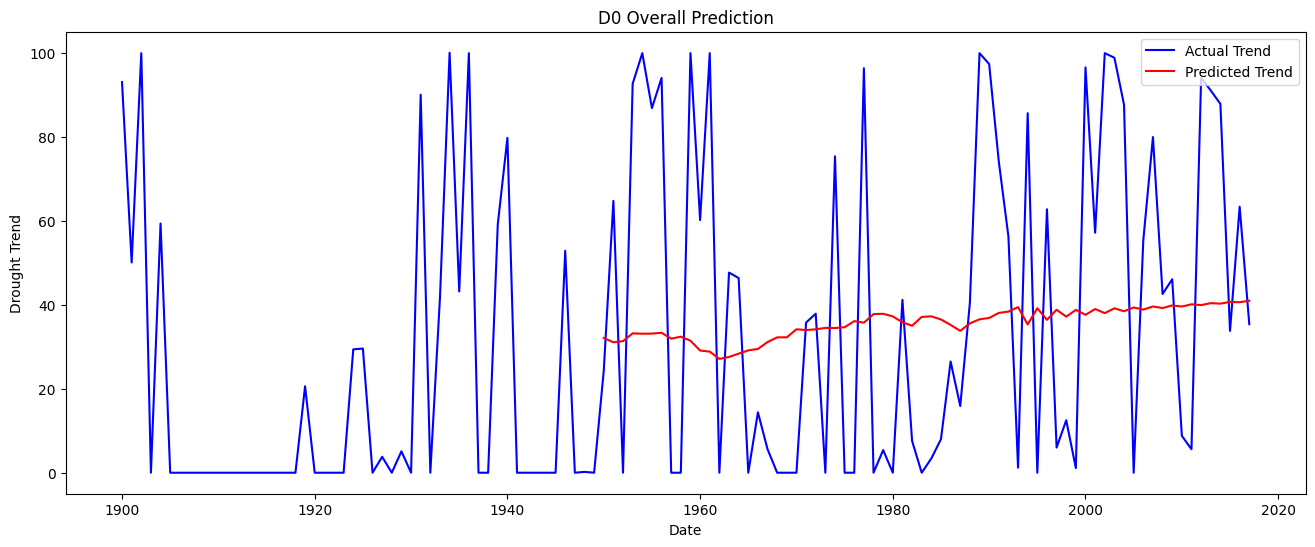

In [50]:
plt.figure(figsize=(16,6))
plt.plot(total_testing_processed, color='blue', label='Actual Trend')
plt.plot(predictions , color='red', label='Predicted Trend')
plt.title('D0 Overall Prediction')
plt.xlabel('Date')
plt.ylabel('Drought Trend')
plt.legend()
plt.show()

# Conclusion

These results are very promising. The next step is to apply them to the other columns in the dataset and forecast out further. Hope you enjoyed this breif analysis. Please upvote and leave feedback!